<a href="https://colab.research.google.com/github/bahramzada/employee-attrition-prediction/blob/main/employee_attrition_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -L -o ibm-hr-analytics-attrition-dataset.zip https://www.kaggle.com/api/v1/datasets/download/pavansubhasht/ibm-hr-analytics-attrition-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 51314  100 51314    0     0   114k      0 --:--:-- --:--:-- --:--:--  114k


In [2]:
!unzip ibm-hr-analytics-attrition-dataset.zip

Archive:  ibm-hr-analytics-attrition-dataset.zip
  inflating: WA_Fn-UseC_-HR-Employee-Attrition.csv  


In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import joblib

# Configuration
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

print("Libraries imported successfully!")

Libraries imported successfully!


In [27]:
df = pd.read_csv('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [28]:
# Load the dataset (Ensure the file path is correct)
# df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
# NOTE: If you are using direct upload in Colab, make sure the variable 'df' is loaded as you did before.

# 1. Drop irrelevant columns that don't provide value to the model
# EmployeeCount, Over18, StandardHours contain only one value. EmployeeNumber is just an ID.
cols_to_drop = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
df_clean = df.drop(columns=cols_to_drop, axis=1)

# 2. Encode the Target Variable 'Attrition'
# Yes -> 1 (Churn), No -> 0 (Stay)
df_clean['Attrition'] = df_clean['Attrition'].map({'Yes': 1, 'No': 0})

print(f"Data Shape after cleaning: {df_clean.shape}")
print(f"Attrition Balance:\n{df_clean['Attrition'].value_counts()}")

Data Shape after cleaning: (1470, 31)
Attrition Balance:
Attrition
0    1233
1     237
Name: count, dtype: int64


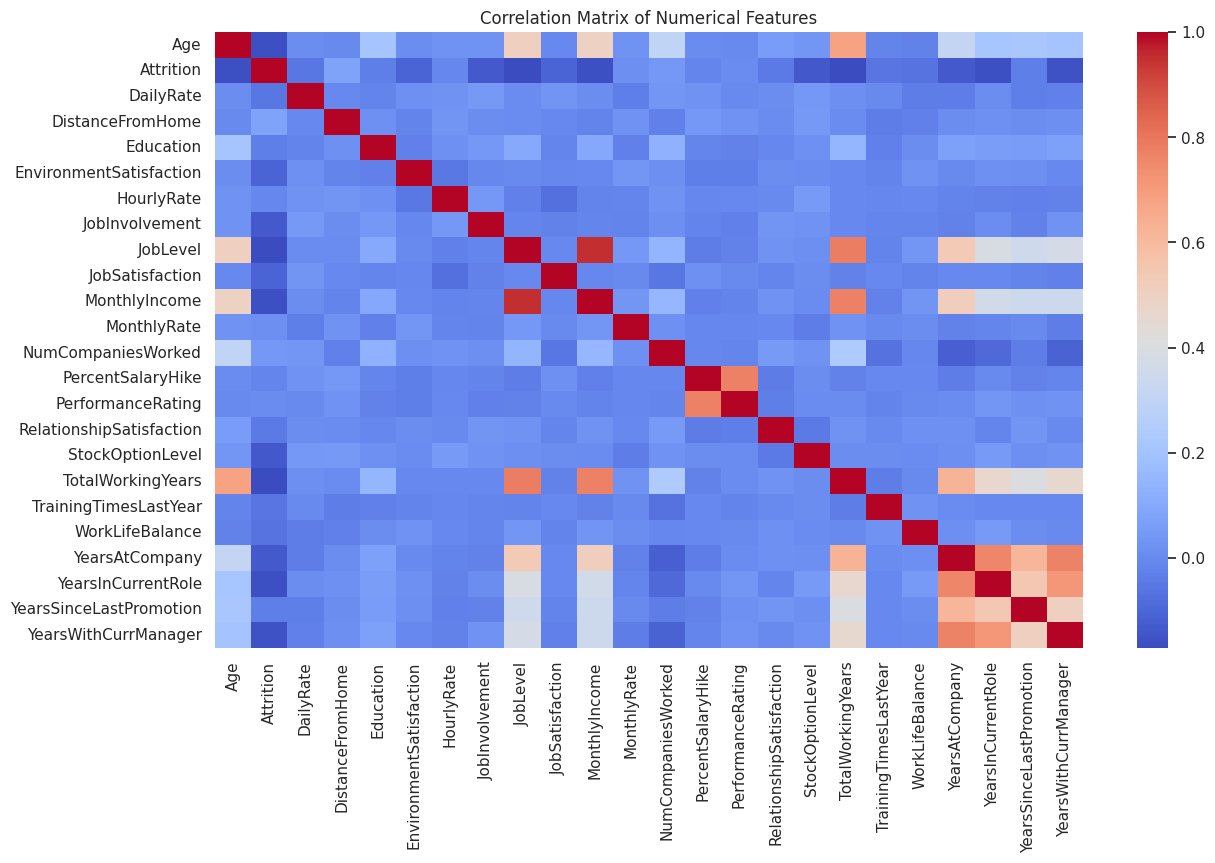

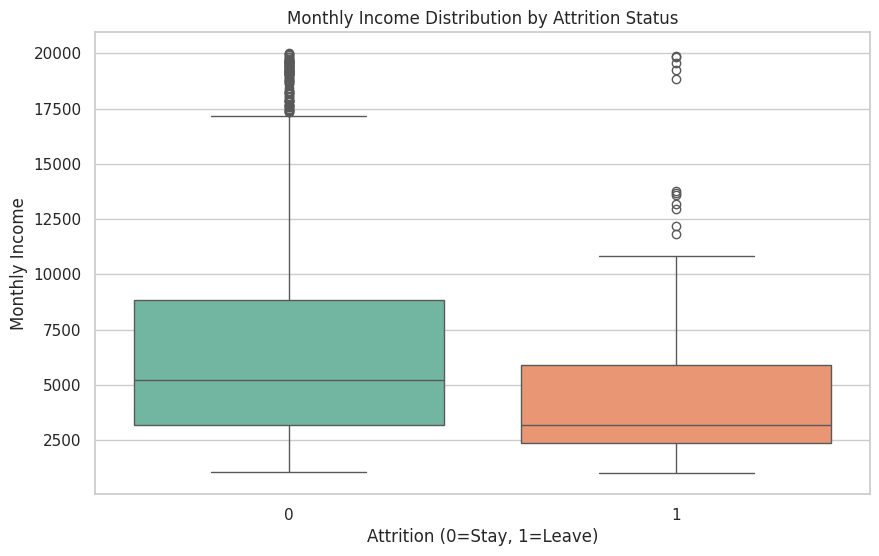

In [42]:
# Visualizing the correlation between numerical features
plt.figure(figsize=(14, 8))
numeric_df = df_clean.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Checking Income Distribution vs Attrition
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df_clean, palette='Set2')
plt.title('Monthly Income Distribution by Attrition Status')
plt.xlabel('Attrition (0=Stay, 1=Leave)')
plt.ylabel('Monthly Income')
plt.show()

In [30]:
# 1. Convert categorical variables into dummy/indicator variables (One-Hot Encoding)
df_encoded = pd.get_dummies(df_clean, drop_first=True)

# 2. Define Features (X) and Target (y)
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

# 3. Split data into Training (80%) and Testing (20%) sets
# We use 'stratify=y' to maintain the same proportion of Yes/No in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (1176, 44)
Testing set shape: (294, 44)


In [31]:
# Apply SMOTE (Synthetic Minority Over-sampling Technique) ONLY to the training data
# This prevents data leakage and helps the model learn the minority class better
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE (Target counts):")
print(y_train.value_counts())
print("\nAfter SMOTE (Target counts):")
print(y_train_smote.value_counts())

Before SMOTE (Target counts):
Attrition
0    986
1    190
Name: count, dtype: int64

After SMOTE (Target counts):
Attrition
0    986
1    986
Name: count, dtype: int64


In [32]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the balanced (SMOTE) dataset
rf_model.fit(X_train_smote, y_train_smote)

print("Model training completed.")

Model training completed.


In [33]:
# 1. Default Predictions (Threshold = 0.5)
y_pred = rf_model.predict(X_test)

print("--- Default Model Performance (Threshold 0.5) ---")
print(classification_report(y_test, y_pred))

# 2. Threshold Tuning (Adjusting to 0.3 to improve Recall)
# Get probabilities for the positive class (Attrition = 1)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Set new threshold
new_threshold = 0.3
y_pred_new = (y_pred_prob >= new_threshold).astype(int)

print("\n--- Tuned Model Performance (Threshold 0.3) ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_new))
print("\nClassification Report:\n", classification_report(y_test, y_pred_new))

--- Default Model Performance (Threshold 0.5) ---
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       247
           1       0.40      0.21      0.28        47

    accuracy                           0.82       294
   macro avg       0.63      0.58      0.59       294
weighted avg       0.79      0.82      0.80       294


--- Tuned Model Performance (Threshold 0.3) ---
Confusion Matrix:
 [[184  63]
 [ 15  32]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.74      0.83       247
           1       0.34      0.68      0.45        47

    accuracy                           0.73       294
   macro avg       0.63      0.71      0.64       294
weighted avg       0.83      0.73      0.77       294



English: Initially, the model with the default threshold (0.5) achieved high overall accuracy (82%) but failed significantly in identifying at-risk employees, with a very low Recall of 21%. It missed the majority of actual leavers. By tuning the decision threshold to 0.3, we successfully prioritized sensitivity, boosting the Recall to 68%. This adjustment means the model now correctly identifies 32 out of 47 potential leavers (up from roughly 10). While this comes with a trade-off in precision (more false positives), it is a strategic improvement for HR, as catching the majority of attrition risks is far more critical than occasional false alarms.

Azərbaycan dili: İlkin model (standart 0.5 həddi ilə) yüksək ümumi dəqiqlik (82%) göstərsə də, işdən çıxma riski olan əməkdaşları müəyyən etməkdə uğursız oldu və yalnız 21% Recall nəticəsi verdi. Qərar qəbuletmə həddini (threshold) 0.3-ə endirməklə biz Recall göstəricisini 68%-ə yüksəltməyə nail olduq. Bu dəyişiklik nəticəsində model artıq şirkəti tərk etmə ehtimalı olan 47 işçidən 32-sini düzgün müəyyən edir. Dəqiqlikdə (Precision) cüzi azalma müşahidə olunsa da, HR strategiyası üçün işçi itkisinin qarşısını almaq adına riskli kadrları vaxtında aşkar etmək, yanlış həyəcan siqnallarından (false positives) qat-qat daha vacibdir.


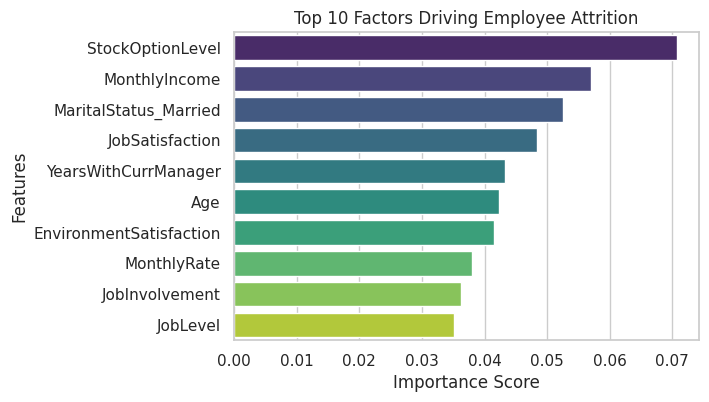

In [36]:
# Calculate feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Top 10 Factors Driving Employee Attrition')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()